# How to build Sentiment Analysis with NLTK and Scikit-learn in Python

In [1]:
#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

#Model Selection and Validation
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Reading and Extracting data from .csv files

In [2]:
train_tweets = pd.read_csv('./train_tweets.csv')
test_tweets = pd.read_csv('./test_tweets.csv')

In [3]:
train_tweets.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
test_tweets.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [5]:
print('train_tweets shape: {}, label 0: {}, label 1: {}'.format(
    train_tweets.shape,
    train_tweets[train_tweets['label']==0].count()['label'],
    train_tweets[train_tweets['label']==1].count()['label'])
)

train_tweets shape: (31962, 3), label 0: 29720, label 1: 2242


## Exploratory Data Analysis

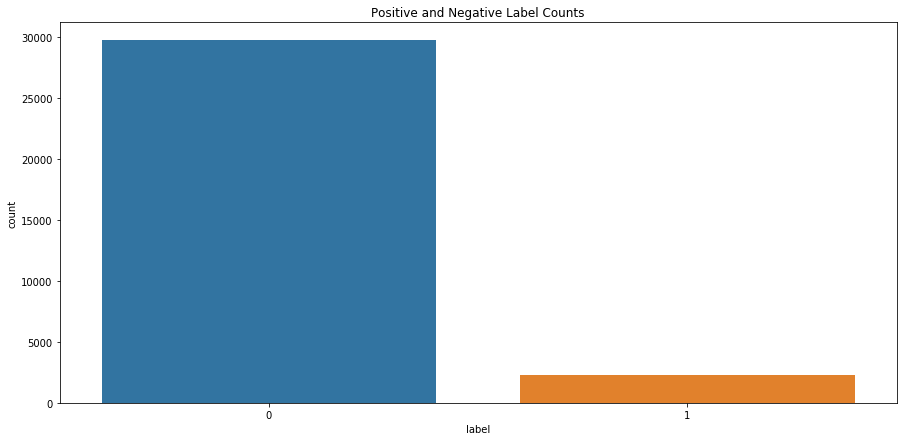

In [6]:
import seaborn as sns

# Positive and Negative Label Counts
fig1 = plt.figure(figsize=(15, 7))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.set_title('Positive and Negative Label Counts')
sns.countplot(x='label', data = train_tweets)

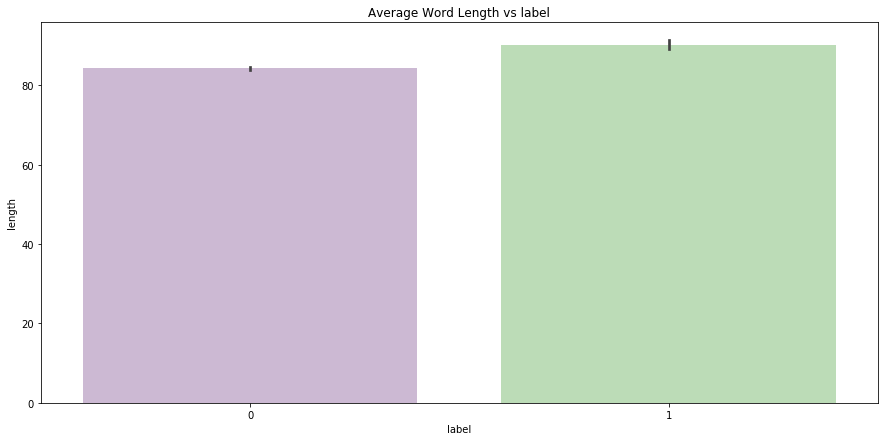

In [7]:
# Average Word Length vs label
train_tweets = train_tweets[['label', 'tweet']]
test = test_tweets['tweet']
train_tweets['length'] = train_tweets['tweet'].apply(len)

fig2 = plt.figure(figsize=(15, 7))
ax2 = fig2.add_subplot(1, 1, 1)
ax2.set_title('Average Word Length vs label')
sns.barplot('label', 'length', data = train_tweets, palette='PRGn')

## Feature engineering

In [8]:
import nltk

In [9]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
def preprocessing(tweet):
    
    # Generating the list of words in the tweet (hastags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    
    # Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    
    # Lemmatize the words in tweets 
    def lemmatization(tweet_list):
        lem = WordNetLemmatizer()
        lemmatized_tweet = []
        for word in tweet_list:
            lemmatized_text = lem.lemmatize(word, 'v')
            lemmatized_tweet.append(lemmatized_text)
        return lemmatized_tweet
    
    new_tweet = form_sentence(tweet)
    no_punc_tweet = no_user_alpha(new_tweet)
    lemmatized_tweet = lemmatization(no_punc_tweet)
    
    return lemmatized_tweet

In [11]:
print(train_tweets['tweet'].iloc[10])

 â #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in may   #blog #silver #gold #forex


In [12]:
print(preprocessing(train_tweets['tweet'].iloc[10]))

['ireland', 'consumer', 'price', 'index', 'mom', 'climb', 'previous', 'may', 'blog', 'silver', 'gold', 'forex']


## Data preprocessing and oversample negative tweets

In [13]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.feature_extraction.text import TfidfVectorizer

"""
min_df=2, discard words appearing in less than 2 documents
max_df=0.9, discard words appering in more than 90% of the documents
sublinear_tf=True, use sublinear weighting
use_idf=True, enable IDF
"""
vec = TfidfVectorizer(
    analyzer=preprocessing,
    min_df=2,
    max_df=0.9,
    sublinear_tf=True,
    use_idf=True
)

train_vec = vec.fit_transform(train_tweets['tweet'])

In [14]:
print(vec.get_feature_names()[:10])
print(len(vec.get_feature_names()))

['aa', 'aaa', 'aaberg', 'aande', 'aap', 'aarhus', 'aaron', 'ab', 'abandon', 'abasel']
12044


In [15]:
import pandas as pd

df = pd.DataFrame(train_vec[:10].toarray(), columns=vec.get_feature_names())
df.head()

,aa,aaa,aaberg,aande,aap,aarhus,aaron,ab,abandon,abasel,...,zuma,zurich,zzzzzzzz,Â,ÐµÐ¹,Ù,ã,ç,ì,ó¾
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
from imblearn.over_sampling import SMOTE

X = train_vec
y = train_tweets['label']
print('X shape: {}, y shape: {}'.format(X.shape, y.shape))

sm = SMOTE(sampling_strategy='auto', random_state=39)
X_resampled, y_resampled = sm.fit_sample(X, y)
print('Resampled label balance:\n{}'.format(y_resampled.value_counts()))

X shape: (31962, 12044), y shape: (31962,)
Resampled label balance:
1    29720
0    29720
Name: label, dtype: int64


## Model selection and train a model

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=39)

print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (39824, 12044)
X_test shape: (19616, 12044)
y_train shape: (39824,)
y_test shape: (19616,)


In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

clf_mnb = MultinomialNB()
clf_rfc = RandomForestClassifier(random_state=39)
clf_gbc = GradientBoostingClassifier(random_state=39)
clf_names = ['MultinomialNB', 'RandomForest', 'GradientBoosting']
clf_types = [clf_mnb, clf_rfc, clf_gbc]

for (i, clf) in enumerate(clf_types):
    clf.fit(X_train, y_train.values.ravel())
    print('Result of {}\n'.format(clf_names[i]))
    predictions = clf.predict(X_test)
    print(classification_report(predictions, y_test))
    print('\n')
    print('Confusion matrix: \n', confusion_matrix(predictions, y_test))
    print('\n')
    print('Accuracy score: ', accuracy_score(predictions, y_test))
    print('\n\n\n')

Result of MultinomialNB

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      9546
           1       0.95      0.92      0.93     10070

    accuracy                           0.93     19616
   macro avg       0.93      0.93      0.93     19616
weighted avg       0.93      0.93      0.93     19616



Confusion matrix: 
 [[9044  502]
 [ 820 9250]]


Accuracy score:  0.9326060358890701




Result of RandomForest

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9632
           1       0.99      0.97      0.98      9984

    accuracy                           0.98     19616
   macro avg       0.98      0.98      0.98     19616
weighted avg       0.98      0.98      0.98     19616



Confusion matrix: 
 [[9525  107]
 [ 339 9645]]


Accuracy score:  0.977263458401305




Result of GradientBoosting

              precision    recall  f1-score   support

           0       0.95      0.73

## (Optional) Test the generated model

In [19]:
# https://twitter.com/realDonaldTrump/status/1309268149242597377
tweet = 'We are providing better care, and more choice, at lower cost. We are delivering a healthier, safer, brighter, and more prosperous future for EVERY citizen in our magnificent land – because we are proudly putting AMERICA FIRST!'
preprocess_tweet = preprocessing(tweet)
print(preprocess_tweet)

['provide', 'better', 'care', 'choice', 'lower', 'cost', 'deliver', 'healthier', 'safer', 'brighter', 'prosperous', 'future', 'EVERY', 'citizen', 'magnificent', 'land', 'proudly', 'put', 'AMERICA', 'FIRST']


In [20]:
# vectorize the tweet
tweet_vec = vec.transform(pd.Series([tweet]))

In [21]:
# predict a label
tweet_prediction = clf_rfc.predict(tweet_vec.toarray())
tweet_prediction = 'positive' if tweet_prediction[0] == '1' else 'negative'
print('{} has been predicted for the tweet {}'.format(tweet_prediction, tweet))

negative has been predicted for the tweet We are providing better care, and more choice, at lower cost. We are delivering a healthier, safer, brighter, and more prosperous future for EVERY citizen in our magnificent land – because we are proudly putting AMERICA FIRST!


## Version

In [22]:
import sklearn
print(sklearn.__version__)

0.22.1


In [23]:
import nltk
print(nltk.__version__)

3.4.4
